# Hulu Recommendation System Notebook

![img](https://github.com/xiaohua-su/Recommender_System/blob/main/Workspace/Zach/images/Hulu_Banner.jpeg?raw=1)

## Overview

The aim of this project is to build a model that provides **top 5 movie recommendations** to a user, based on their **ratings of other movies** from Hulu. Our audience in this case is the **Hulu Technology Team** headed by the *CTO* of Hulu. They are holding a competition to upgrade their current machine learning algorithm that oversees the movie recommendations given to a Hulu subscriber. 

## Business/Industry Understanding 

Todays streaming landscape is vast and diverse, with over *1 billion users worldwide* and generating over *500 billion dollars* in revenue.  Hulu currently holds *11% of the market share* within the streaming industry, trailing behind *Netflix* with *25% of the market*, *Amazon Prime Video* with *18%*, *HBO Max* with *17%* and *Disney Plus* *with 14%*.  It's also important to note that *85%* of Hulu users are also subscribed to Netflix.  Currently, Hulu uses a *item-based collaborative filtering algorithm*, this is a successful approach commonly used by many recommender systems. This type of recommender system takes into consideration the ratings given to movies and shows by users as the sole source of information for learning to make recommendations. 

## Data Understanding

Our dataset is from Grouplens which got it's information from imdb and tmdb. The ratings and movies were taken between 1996 to 2018.The data has over 100,000 movie ratings given by 610 different users for about 9700 movies. Each user had reviewed  at least 20 different movies. Due to time constraints, however, this model was built off of 100,000 movies rating versus 1.9 million ratings available. 

# Imports

`Surprise` was the main library we used to produce our *collaborative filtering model*.This library has endogenous methods of splitting our data set, cross validating, performing grid searches as well various different algorithms that can be used to build recommendation systems. 

As you go through this notebook, you will see that we had to use a combination of both surprise and `scikit-learn` methods to ensure the successful deployment of model. Since the syntax of `surprise` and `sklearn` are similar, this made this process much more efficient. This also ensures that the notebook would be readable to anyone with a background in *data science*. We mainly utilized `surprise` to transform the data set to a suitable data format that can be used in *recommendation systems*. We also employed `pickling` to make loading onto any new computer an easier process. 

In [1]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 3.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633703 sha256=576ecb63f705a1e42e7333ff318cb8de05892675b52bd0597d3a6a881a773fcd
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import pandas as pd

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate,GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly,\
                                            NormalPredictor, KNNBasic
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

Our Exploratory Data Analysis also includes *data cleaning* and *reformatting*. Below we use pandas to load the two csv files into a pandas data frame

In [4]:
movies = pd.read_csv('/content/drive/MyDrive/ml-latest/movies.csv')
rating = pd.read_csv('/content/drive/MyDrive/ml-latest/ratings.csv')

In [5]:
#looking at the movies df
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


The movies data set has **9742 rows** and **3 columns**, where each row represents **one movie**. The first column : `movieId` corresponds to a **unique id** that defines each movie in this dataset. The second column : `title`  contains the movie title which, in this case, is a combination of both the title of the movie and the year it was released. The final column is `genres` and it contains the `genres` of the movie, some movies are tied to multiple genres. For example, the movie *Toy Story* is considered a Children's movie, but also an action movie, as well as adventure, comedy and fantasy.

In [6]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [7]:
movies.title.value_counts()

Slow Burn (2000)                                            2
Blackout (2007)                                             2
20,000 Leagues Under the Sea (1997)                         2
Beneath (2013)                                              2
Deranged (2012)                                             2
                                                           ..
Euridice BA 2O37 (Evridiki BA 2O37) (1975)                  1
Stoplight Society, The (La Sociedad del Semáforo) (2010)    1
Flying Fleet, The (1929)                                    1
Savages (2012)                                              1
Leal (2018)                                                 1
Name: title, Length: 58020, dtype: int64

In [8]:
movies.title.duplicated().sum()

78

First, we established that there were **no nulls** in the data frame. Then we checked to see whether there were any **duplicates** by looking at the `value_counts` specific to *movie titles* and we noticed **78 duplicated data points**, so we dropped the duplicates present in the data. We then reconfirmed that our data had no duplicates and the size of new data frame without duplicates was **58020**, **78 less** than the original **58098**.

In [9]:
#Drop the 78 duplicated movie titles
movies.drop_duplicates(subset='title', inplace=True)

In [10]:
#Sanity check to ensure all duplicates were dropped from title column

movies.title.duplicated().sum()

0

In [11]:
movies[movies.title.duplicated() == True]

,movieId,title,genres


In [12]:
len(movies)

58020

In [13]:
# Split title column into two new columns: Title and year 

movies['Title'] = movies['title'].str.split('(', n=1, expand=True)[0]

movies['year_released'] = movies['title'].str.split('(', n=1, expand=True)[1]

We decided to format the `title` column, so we split it by the `delimiter '()'` so that we could separate the `title` and `year_released`. We felt that we wanted to isolate these two variables as we wanted to see what effect `year_released` would have on the model.  

In [14]:
# Drop original column title

movies.drop(columns='title', inplace=True)

In [15]:
# Sanity Check 
movies

,movieId,genres,Title,year_released
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995)
1,2,Adventure|Children|Fantasy,Jumanji,1995)
2,3,Comedy|Romance,Grumpier Old Men,1995)
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995)
4,5,Comedy,Father of the Bride Part II,1995)
...,...,...,...,...
58093,193876,(no genres listed),The Great Glinka,1946)
58094,193878,Comedy,Les tribulations d'une caissière,2011)
58095,193880,Drama,Her Name Was Mumu,2016)
58096,193882,Adventure|Drama|Horror|Sci-Fi,Flora,2017)


In [16]:
movies[movies['genres'] == '(no genres listed)'	]

,movieId,genres,Title,year_released
16662,83773,(no genres listed),Away with Words,San tiao ren) (1999)
16677,83829,(no genres listed),Scorpio Rising,1964)
16856,84768,(no genres listed),Glitterbug,1994)
17178,86493,(no genres listed),"Age of the Earth, The",A Idade da Terra) (1980)
17343,87061,(no genres listed),Trails,Veredas) (1978)
...,...,...,...,...
58064,193815,(no genres listed),Tempting Fate,1998)
58079,193849,(no genres listed),Rafinha Bastos: Ultimatum,2018)
58082,193855,(no genres listed),"Spring Night, Summer Night",1967)
58090,193870,(no genres listed),Isabelle Eberhardt,1991)


When we originally ran the formatting code, it didn't delete the *close* parenthesis, so we had to write additional code above to fix that and ensure clean data. 

In [17]:
# Format year_released column

movies['year_released'] = movies.year_released.str.replace(')', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# Sanity Check to ensure formatting was completed
movies

,movieId,genres,Title,year_released
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Adventure|Children|Fantasy,Jumanji,1995
2,3,Comedy|Romance,Grumpier Old Men,1995
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Comedy,Father of the Bride Part II,1995
...,...,...,...,...
58093,193876,(no genres listed),The Great Glinka,1946
58094,193878,Comedy,Les tribulations d'une caissière,2011
58095,193880,Drama,Her Name Was Mumu,2016
58096,193882,Adventure|Drama|Horror|Sci-Fi,Flora,2017


In [19]:
movies['genres']=[row.strip().lower().replace('|',', ') for row in movies['genres']]

The code above is to change the genres from its current format into a list that we can iterate over in our final function

In [20]:
movies

,movieId,genres,Title,year_released
0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995
1,2,"adventure, children, fantasy",Jumanji,1995
2,3,"comedy, romance",Grumpier Old Men,1995
3,4,"comedy, drama, romance",Waiting to Exhale,1995
4,5,comedy,Father of the Bride Part II,1995
...,...,...,...,...
58093,193876,(no genres listed),The Great Glinka,1946
58094,193878,comedy,Les tribulations d'une caissière,2011
58095,193880,drama,Her Name Was Mumu,2016
58096,193882,"adventure, drama, horror, sci-fi",Flora,2017


In [21]:
#checking rating df
rating

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


The ratings data frame has **27,753,444 rows** and **4 columns**, where each row is one rating given by a specific user to a specific movie. The first column : `userId` corresponds to a `unique id` that identifies the **specific user** that rated the **specific movie**, denoted by the second column: `movieId`. This `movieId` is the same identifying key that is present in the `movies` data frame. The third column represents the `rating` that a user gave the movie, on a **1-5 rating scale**. Lastly, the final column corresponds to the `date and time` the rating was made, in the format of a `UNIX timestamp`.

In [22]:
#converted timestamp to datetime
rating['timestamp'] = pd.to_datetime(rating['timestamp'], unit='s')

We converted the `UNIX timestamp` into a `date time object`, to determine if we could incorporate the element of time as a feature within our moldel.  However, after reviewing the data, we decided that these datasets will change over time, and are not appropriate for reporting research results. 

In [23]:
rating.rating.value_counts(normalize=True)

4.0    0.266443
3.0    0.198738
5.0    0.146689
3.5    0.122664
4.5    0.085523
2.0    0.066681
2.5    0.049486
1.0    0.031932
0.5    0.015940
1.5    0.015903
Name: rating, dtype: float64

In [24]:
rating.duplicated().sum()

0

In [25]:
rating.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

First, we established that there were **no nulls** in the data frame, then we checked to see whether there were any **duplicates**, so we did a `value_counts` specific to ratings and confirmed there are **no duplicates**.

In [26]:
# merging rating and movies
movie_rating = movies.merge(rating, on='movieId', how='outer')

In [27]:
movie_rating

,movieId,genres,Title,year_released,userId,rating,timestamp
0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.0,4.0,2005-04-17 19:25:37
1,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,10.0,5.0,2000-01-26 11:24:10
2,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,14.0,4.5,2015-09-13 18:36:15
3,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,15.0,4.0,2013-06-09 20:34:23
4,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,22.0,4.0,2009-03-21 08:03:51
...,...,...,...,...,...,...,...
27757643,181655,NaN,NaN,NaN,241786.0,3.0,2017-12-05 15:21:33
27757644,160356,NaN,NaN,NaN,258724.0,3.0,2018-07-30 18:55:12
27757645,185925,NaN,NaN,NaN,262278.0,4.0,2018-03-26 16:47:59
27757646,191713,NaN,NaN,NaN,262584.0,3.5,2018-07-27 13:20:49


In [28]:
movie_rating.dropna(inplace=True)

In [29]:
movie_rating['userId'].nunique()

283225

The code above was to determine how many unique users contributed to the total ratings, in this case, 283,225 unique users made 27,753,444 ratings of 58,020 movies.

In [30]:
movie_rating

,movieId,genres,Title,year_released,userId,rating,timestamp
0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.0,4.0,2005-04-17 19:25:37
1,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,10.0,5.0,2000-01-26 11:24:10
2,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,14.0,4.5,2015-09-13 18:36:15
3,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,15.0,4.0,2013-06-09 20:34:23
4,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,22.0,4.0,2009-03-21 08:03:51
...,...,...,...,...,...,...,...
27756079,193878,comedy,Les tribulations d'une caissière,2011,176871.0,2.0,2018-09-25 11:31:20
27756080,193880,drama,Her Name Was Mumu,2016,81710.0,2.0,2018-09-25 14:37:12
27756081,193882,"adventure, drama, horror, sci-fi",Flora,2017,33330.0,2.0,2018-09-25 15:48:32
27756082,193886,"action, crime, drama",Leal,2018,206009.0,2.5,2018-09-25 23:24:14


In [31]:
movie_rating['userId'].value_counts()

123100.0    23634
117490.0     9277
134596.0     8368
212343.0     7876
242683.0     7514
            ...  
142774.0        1
201727.0        1
116816.0        1
100074.0        1
687.0           1
Name: userId, Length: 283225, dtype: int64

In [32]:
movie_rating['userId'].value_counts().describe()

count    283225.000000
mean         97.961483
std         212.610884
min           1.000000
25%          15.000000
50%          30.000000
75%          95.000000
max       23634.000000
Name: userId, dtype: float64

In [33]:
len(movie_rating['rating'])/len(set(movie_rating['userId']))

97.96148291993998

In [34]:
(movie_rating['userId'].value_counts() <= 4).sum()

16251

On average a user rates 98 movies. Each user has at least 1 rating. 16,251 users have rated less than 5 movies. Cold Start issue.

In [35]:
movie_rating['Title'].value_counts().describe()

count    50017.000000
mean       554.714217
std       3064.110604
min          1.000000
25%          2.000000
50%          7.000000
75%         54.000000
max      97999.000000
Name: Title, dtype: float64

In [36]:
movie_rating['Title'].value_counts().value_counts()

1       9145
2       5664
3       3598
4       2456
5       1875
        ... 
4897       1
4896       1
4894       1
4883       1
2558       1
Name: Title, Length: 3949, dtype: int64

In [37]:
movie_rating['Title'].value_counts()

Shawshank Redemption, The     97999
Forrest Gump                  97040
Pulp Fiction                  92406
Silence of the Lambs, The     87899
Matrix, The                   84545
                              ...  
Spies of Mississippi              1
The Last White Knight             1
The Model Solution                1
Gogol Bordello Non-Stop           1
7 Hours of Violence               1
Name: Title, Length: 50017, dtype: int64

In [38]:
(movie_rating['Title'].value_counts() <= 4).sum()

20863

Shawshank Redemption has the most ratings. There are a considerable number of movies that have less than 5 ratings (20,863).

# Splits

The `train test split` process was a little bit different than usual. This is because of how the `surprise` library's methods for `cross validation` and `GridSearch` are comprised. A different input type is needed for `GridSearch` and `cross validation` methods compared to the `.fit` and `.test` methods. The documentation recommends doing `cross validation` **OR** the `train test split`. Since we wanted to do both we had to `train test split` **twice:** `train_data` and `test_data`, defined below are used for `fitting` and `cross validation` while `train_data2` is used for predictions. 

In [39]:
#for function building/final model
reader = Reader(rating_scale=(1, 5))
complete_data = Dataset.load_from_df(movie_rating[['userId', 'movieId', 'rating']], reader)

In [40]:
#use sklearn for model selection/choosing 
train, test = train_test_split(movie_rating, random_state=42)

reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
test_data = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader)


train_data2 = train_data.build_full_trainset()
test_data2 = test_data.build_full_trainset().build_testset()

# Modeling

### Baseline/dummy

The first step in our **iterative modeling process** is to create and test a `dummy model`, which will act as our `base line RSME (root mean squared error) score` that we compare to when judging the **validity** and **performance** of our future models.  

In [41]:
dummy_model = NormalPredictor()
#cross_validate(dummy_model, train_data, measures=['RMSE'], cv=5, verbose=True)

In [42]:
predictions = dummy_model.fit(train_data2).test(test_data2)
baseline_rsme = accuracy.rmse(predictions)
baseline_rsme

RMSE: 1.4493


1.449312443601635

Nearing RAM limit in Google Colab. Will likely have to save final dataset and split models into different notebooks.

### KNNBasics

**The grid searches took a while to run, as such they are commented out for this notebook. The best parameters for each grid search is inputed into cross validation**

The `k-nearest neighbors` (KNN) algorithm is a *simple*, *supervised machine learning* algorithm that can be used to solve both `classification` and `regression` problems. In this case, we are using it as the basis for our `recommendation system`. The premise is that the rating of movies *unseen* by the user will be **predicted** using *ratings of similar users*. In this case, the nearest "neighbors".

In [ ]:
# param_grid = {'k':[10, 50, 100],'min_k': [1, 5, 10]}
# base_model = GridSearchCV(KNNBasic,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
# base_model.fit(train_data)

In [ ]:
# base_model.best_params

In [ ]:
#trying different parameters
# param_grid = {'k':[5, 10, 15],'min_k': [1, 5, 10]}
# base_model = GridSearchCV(KNNBasic,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
# base_model.fit(train_data)

In [ ]:
# base_model.best_params

In [ ]:
# param_grid = {'k':[10, 15, 20],'min_k': [1, 5, 10]}
# base_model = GridSearchCV(KNNBasic,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
# base_model.fit(train_data)

In [ ]:
# base_model.best_params

We performed a `GridSearch` until the `hyper-parameters` were tuned to what is considered the *optimal amount*.

#### KNN Cross Validation

In [ ]:
#instantiate KNN model 
model1=KNNBasic(k=15, min_k=5)

In [ ]:
#instaniatite and perform cross val with training data
knn_cv_results = cross_validate(model1, train_data, measures=['RMSE'], cv=5, verbose=True)
knn_cv_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9498  0.9526  0.9621  0.9536  0.9411  0.9519  0.0067  
Fit time          0.07    0.07    0.07    0.07    0.07    0.07    0.00    
Test time         0.52    0.49    0.55    0.51    0.61    0.54    0.04    


{'test_rmse': array([0.94981707, 0.95256237, 0.96208644, 0.95364915, 0.94113532]),
 'fit_time': (0.07169246673583984,
  0.0717618465423584,
  0.06754112243652344,
  0.06877017021179199,
  0.0717618465423584),
 'test_time': (0.5158190727233887,
  0.49244117736816406,
  0.5522491931915283,
  0.5122096538543701,
  0.6079607009887695)}

In [ ]:
#use model to predict
model1.predict(uid=10, iid = 20)
#this model just predicted what user 10 would predict movie 20

Prediction(uid=10, iid=20, r_ui=None, est=2.7014774642183195, details={'actual_k': 10, 'was_impossible': False})

In [ ]:
knn_rsme = knn_cv_results['test_rmse'].mean()
knn_rsme

0.9518500720049218

Looking at the output above we can determine that our model predicted that **user 10** would rate **movie 20** a **2.5** give or take our **RSME** which is **.95**.

### SVD

After defining our `baseline model` and exploring the `KNN` algorithm, we decided to try using `Singular Value Decomposition (SVD)` algorithm, in the hopes that it would improve the `accuracy` of our model and lower the `RSME`. The `surprise` library uses a form of `SVD` called `Funk's SVD`, the premise behind it is a **matrix factorization-based model**. This means it *transforms* a **user-item matrix** (in our case, a *user-movie ratings matrix*)into latent factor matrices. It is also important to note that errors are *minimized* using `stochastic gradient descent`.  This means that both `regularization` and `learning rate` are `hyper-parameters` that we can tune. Number of `factors` and number of `epochs` are also `hyper-parameters` we tuned.

In [ ]:
model2 = SVD()

In [ ]:
cross_validate(model2, train_data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8789  0.8800  0.8756  0.8823  0.8831  0.8800  0.0027  
Fit time          2.61    2.64    2.58    2.52    2.44    2.56    0.07    
Test time         0.08    0.07    0.08    0.07    0.13    0.09    0.02    


{'test_rmse': array([0.87887842, 0.88000044, 0.87560258, 0.88229692, 0.88306141]),
 'fit_time': (2.607375383377075,
  2.639669179916382,
  2.577373504638672,
  2.5218799114227295,
  2.4448211193084717),
 'test_time': (0.08072996139526367,
  0.06677699089050293,
  0.07973456382751465,
  0.06677699089050293,
  0.13256096839904785)}

In [ ]:
# param_grid = {'n_factors':[10,20,50],'n_epochs': [5, 10, 15], 'lr_all': [0.002,0.005,0.01],
#              'reg_all': [0.2,0.4,0.6]}
# gs_model2 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
# gs_model2.fit(train_data)

In [ ]:
# gs_model2.best_params

In [ ]:
# param_grid = {'n_factors':[25, 50, 75],'n_epochs': [15, 30, 45], 'lr_all': [0.01,0.05,0.1],
#              'reg_all': [0.1,0.2,0.3]}
# gs_model2 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
# gs_model2.fit(train_data)

In [ ]:
# gs_model2.best_params

In [ ]:
cross_validate(SVD(n_factors=75,n_epochs=45,lr_all=0.01,reg_all=0.1), train_data, measures=['RMSE'], 
               cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8564  0.8516  0.8676  0.8614  0.8663  0.8607  0.0060  
Fit time          4.64    4.72    5.04    4.90    4.55    4.77    0.18    
Test time         0.07    0.16    0.07    0.09    0.09    0.10    0.04    


{'test_rmse': array([0.85644098, 0.85157425, 0.86763833, 0.86141483, 0.86633767]),
 'fit_time': (4.635298252105713,
  4.717840194702148,
  5.039127349853516,
  4.903642177581787,
  4.554098129272461),
 'test_time': (0.06677651405334473,
  0.1634528636932373,
  0.06976771354675293,
  0.09376382827758789,
  0.08871006965637207)}

In [ ]:
# param_grid = {'n_factors':[75, 100, 125],'n_epochs': [45, 60, 75], 'lr_all': [.005, 0.01, .015],
#              'reg_all': [.05, 0.1, 0.15]}
# gs_model2 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
# gs_model2.fit(train_data)

In [ ]:
# gs_model2.best_params

In [ ]:
svd_cv_results = cross_validate(SVD(n_factors=125,n_epochs=45,lr_all=0.015,reg_all=0.1), train_data, measures=['RMSE'], 
               cv=5, verbose=True)
svd_cv_results

In [ ]:
svd_rsme = svd_cv_results['test_rmse'].mean()
svd_rsme

0.8591781610881813

### NMF

The **final algorithm** we explored in the `surprise` Library was `Non-negative Matrix Factorization (NMF)`. The only difference between this algorithm and the previous algorithm `SVD` is that in `NMF`, a specific *step size* is set for the `stochastic gradient descent` process of `regularization`. This is done to ensure that all **user** and **item factors** are kept positive. While this model can be prone to **over-fitting**, this can be mitigated with steps to **reduce the dimensionality** of our **data/factors**. 

In [ ]:
model3 = NMF()

In [ ]:
cross_validate(model3, train_data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9482  0.9284  0.9456  0.9432  0.9248  0.9381  0.0095  
Fit time          3.96    3.58    3.64    4.36    3.80    3.87    0.28    
Test time         0.06    0.06    0.06    0.07    0.14    0.08    0.03    


{'test_rmse': array([0.94823616, 0.92843048, 0.94562281, 0.94320069, 0.92479912]),
 'fit_time': (3.9567813873291016,
  3.582054615020752,
  3.643934488296509,
  4.355371952056885,
  3.7997536659240723),
 'test_time': (0.059800148010253906,
  0.058803558349609375,
  0.0627899169921875,
  0.06729555130004883,
  0.1445159912109375)}

In [ ]:
# param_grid = {'n_factors':[10,15,20],'n_epochs': [25, 50, 75]}
# gs_model3 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
# gs_model3.fit(train_data)

In [ ]:
# gs_model3.best_params

In [ ]:
cross_validate(NMF(n_factors=10,n_epochs=25), train_data, measures=['RMSE'], 
               cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9674  0.9826  0.9737  0.9728  0.9682  0.9730  0.0054  
Fit time          1.73    1.62    1.57    1.59    1.87    1.68    0.11    
Test time         0.06    0.14    0.08    0.07    0.14    0.10    0.04    


{'test_rmse': array([0.96741159, 0.98263188, 0.97374586, 0.97280672, 0.96821345]),
 'fit_time': (1.7255523204803467,
  1.615922212600708,
  1.5716705322265625,
  1.5916743278503418,
  1.8737311363220215),
 'test_time': (0.060796499252319336,
  0.13953733444213867,
  0.07774019241333008,
  0.07275772094726562,
  0.14452052116394043)}

In [ ]:
# param_grid = {'n_factors':[3,5,10],'n_epochs': [15, 20, 25]}
# gs_model3 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
# gs_model3.fit(train_data)

In [ ]:
# gs_model3.best_params

In [ ]:
# param_grid = {'n_factors':[10, 20, 30],'n_epochs': [25, 50, 75]}
# gs_model3 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'])
# gs_model3.fit(train_data)

In [ ]:
# gs_model3.best_params

In [ ]:
nmf_cv_results = cross_validate(NMF(n_factors=20,n_epochs=50), train_data, measures=['RMSE'], 
               cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9363  0.9346  0.9375  0.9444  0.9342  0.9374  0.0037  
Fit time          4.06    4.05    4.16    3.87    3.88    4.00    0.11    
Test time         0.06    0.07    0.06    0.06    0.14    0.08    0.03    


In [ ]:
nmf_rsme = nmf_cv_results['test_rmse'].mean()
nmf_rsme

0.9374113693612329

### Model Performance

In [ ]:
baseline_rsme, knn_rsme, svd_rsme, nmf_rsme

(1.4299688225641143,
 0.9518500720049218,
 0.8591781610881813,
 0.9374113693612329)

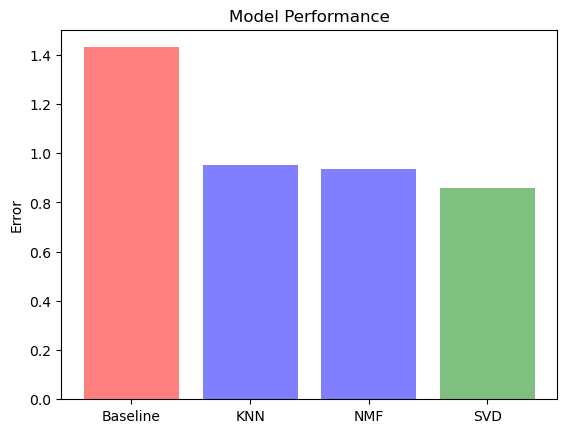

In [ ]:
objects = ('Baseline', 'KNN', 'NMF', 'SVD')
y_pos = np.arange(len(objects))
performance = [baseline_rsme, knn_rsme, nmf_rsme, svd_rsme]

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue', 'blue', 'green'])
plt.xticks(y_pos, objects)
plt.ylabel('Error')
plt.title('Model Performance')

plt.savefig('./images/model_performance.png', dpi = 200 )

plt.show();

When we compare the **best model** with *each different* algorithm explored, with `hyper-parameters` tuned to *optimize*, we found that our **best model** using `SVD` is the model which exhibits the *lowest* `RSME` in `cross validation`. Therefore that is the model we have determined to be our **final model**.

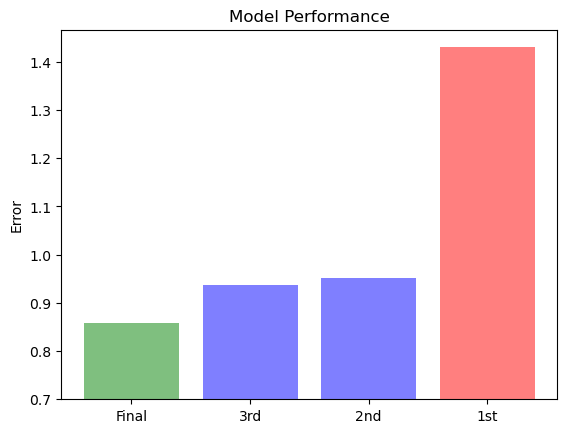

In [ ]:
objects = ("Final", "3rd", "2nd", "1st")
y_pos = np.arange(len(objects))
performance = [svd_rsme-.7, nmf_rsme-.7, knn_rsme-.7, baseline_rsme-.7]

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['green', 'blue', 'blue', 'red'], bottom=.7)
plt.xticks(y_pos, objects)
plt.ylabel('Error')
plt.title('Model Performance')

plt.savefig('./images/model_performance_presentation.png', dpi = 200 )

plt.show();

The above graph is for our nontechnical presentation. 

### Final Model Evaluation

In [ ]:
final_model = SVD(n_factors=125,n_epochs=45,lr_all=0.015,reg_all=0.1)

In [ ]:
predictions = final_model.fit(train_data2).test(test_data2)

In [ ]:
accuracy.rmse(predictions)

RMSE: 0.8599


0.8599180315314878

## Deployment

In terms of deploying our final model, we used retrained our final model on the complete data set. To fit the complete data set, we transformed it into a surprise train set. 

In [ ]:
#create trainset object from surprise dataset
full_data = complete_data.build_full_trainset()

In [ ]:
final_model.fit(full_data)

#### Function Building

Below is the process in which we built our deployment function. The purpose of this function is to take 3 inputs from the reader and give movie recommendations based on those inputs

In [ ]:
#setting index to ensure dropping
userdf = movie_rating.set_index('userId')

First we reset the index in our merged data frame (*movie_rating*)  to have *userId* as the index. This is to ensure the matrix that is inputted into our recommender function is in the correct format.

In [ ]:
userdf

,movieId,genres,Title,year_released,rating,timestamp
userId,,,,,,
1.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.0,2000-07-30 18:45:03
5.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.0,1996-11-08 06:36:02
7.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.5,2005-01-25 06:52:26
15.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,2.5,2017-11-13 12:59:30
17.0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995,4.5,2011-05-18 05:28:03
...,...,...,...,...,...,...
184.0,193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017,4.0,2018-09-16 14:44:42
184.0,193583,"animation, comedy, fantasy",No Game No Life: Zero,2017,3.5,2018-09-16 14:52:25
184.0,193585,drama,Flint,2017,3.5,2018-09-16 14:56:45


In [ ]:
#create 
userdf1 = userdf['movieId']

Since we reset our index to user id we can create a data frame that is essentially a list of all the movies that each specific user has seen and rated.

In [ ]:
userdf1.loc[9,]

userId
9.0      41
9.0     187
9.0     223
9.0     371
9.0     627
9.0     922
9.0     923
9.0    1037
9.0    1095
9.0    1198
9.0    1270
9.0    1674
9.0    1987
9.0    2011
9.0    2012
9.0    2023
9.0    2300
9.0    2877
9.0    2901
9.0    3173
9.0    3328
9.0    3735
9.0    4131
9.0    4558
9.0    4993
9.0    5218
9.0    5378
9.0    5445
9.0    5447
9.0    5451
9.0    5481
9.0    5507
9.0    5841
9.0    5843
9.0    5872
9.0    5890
9.0    5891
9.0    5893
9.0    5902
9.0    5952
9.0    5956
9.0    5962
9.0    5965
9.0    5988
9.0    6001
9.0    6044
Name: movieId, dtype: int64

This is a sanity check, we're trying to create a list of movies that one specific user (user 9) has seen. The purpose of this is to take these movies out of the data set that is being predicted on. This is because we don't want to recommended movies to a user that they have already seen/rated.

In [ ]:
user_rate = list(userdf1.loc[9,])

In [ ]:
user_rate

[41,
 187,
 223,
 371,
 627,
 922,
 923,
 1037,
 1095,
 1198,
 1270,
 1674,
 1987,
 2011,
 2012,
 2023,
 2300,
 2877,
 2901,
 3173,
 3328,
 3735,
 4131,
 4558,
 4993,
 5218,
 5378,
 5445,
 5447,
 5451,
 5481,
 5507,
 5841,
 5843,
 5872,
 5890,
 5891,
 5893,
 5902,
 5952,
 5956,
 5962,
 5965,
 5988,
 6001,
 6044]

In [ ]:
#setting index so we can drop base off of specific movieId
moviedf = movies.set_index('movieId')

Once we reset the index in moviedf, we can use the list of movies the user has already rated and remove them from the data set that our function will iterate over to provide recommendations.

In [ ]:
moviedf

,genres,Title,year_released
movieId,,,
1,"adventure, animation, children, comedy, fantasy",Toy Story,1995
2,"adventure, children, fantasy",Jumanji,1995
3,"comedy, romance",Grumpier Old Men,1995
4,"comedy, drama, romance",Waiting to Exhale,1995
5,comedy,Father of the Bride Part II,1995
...,...,...,...
193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017
193583,"animation, comedy, fantasy",No Game No Life: Zero,2017
193585,drama,Flint,2017


In [ ]:
moviedf.drop(user_rate, inplace = True)

In [ ]:
moviedf

,genres,Title,year_released
movieId,,,
1,"adventure, animation, children, comedy, fantasy",Toy Story,1995
2,"adventure, children, fantasy",Jumanji,1995
3,"comedy, romance",Grumpier Old Men,1995
4,"comedy, drama, romance",Waiting to Exhale,1995
5,comedy,Father of the Bride Part II,1995
...,...,...,...
193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017
193583,"animation, comedy, fantasy",No Game No Life: Zero,2017
193585,drama,Flint,2017


In [ ]:
#reset index to be able to use .apply on the movieId
moviedf = moviedf.reset_index()

We have to reset the index to the original index of the movie data frame so we can use it in an .apply method and use movieId as a feature/column in our final model

In [ ]:
moviedf

,movieId,genres,Title,year_released
0,1,"adventure, animation, children, comedy, fantasy",Toy Story,1995
1,2,"adventure, children, fantasy",Jumanji,1995
2,3,"comedy, romance",Grumpier Old Men,1995
3,4,"comedy, drama, romance",Waiting to Exhale,1995
4,5,comedy,Father of the Bride Part II,1995
...,...,...,...,...
9686,193581,"action, animation, comedy, fantasy",Black Butler: Book of the Atlantic,2017
9687,193583,"animation, comedy, fantasy",No Game No Life: Zero,2017
9688,193585,drama,Flint,2017
9689,193587,"action, animation",Bungo Stray Dogs: Dead Apple,2018


In [ ]:
moviedf['est_rating'] = moviedf['movieId'].apply(lambda x: final_model.predict(9, x).est)
moviedf.sort_values(by='est_rating', ascending=False, inplace=True)

The code above uses our final model to estimate what users would have rated the movies they have not seen yet,as well as adding the predicted rating as a new column in our data frame. The movies with the highest predicted ratings will be the ones that our recommendation system will recommend to the user. 

In [ ]:
moviedf.head(5)

,movieId,genres,Title,year_released,est_rating
5574,27156,"action, animation, drama, fantasy, sci-fi",Neon Genesis Evangelion: The End of Evangelion,Shin seiki Evangelion Gekijô-ban: Air/Magokoro...,4.628788
3877,5490,"action, comedy",The Big Bus,1976,4.563338
4544,6818,"drama, war",Come and See,Idi i smotri (1985,4.546410
4736,7121,"comedy, romance",Adam's Rib,1949,4.540400
9567,177593,"crime, drama","Three Billboards Outside Ebbing, Missouri",2017,4.526741


The above data frame is the first simple version of the results of our deployed function. 

#### Function

In [ ]:
#creating a variable that only has the userid and movies that they've rated
#this uses the original train dataset not surprise's version
users_movies_seen = movie_rating[['movieId', 'userId']]
#setting user id as index to make it easier to use loc on it
users_movies_seen = users_movies_seen.set_index('userId')

In [ ]:
users_movies_seen.to_csv('./data/users_movies_seen.csv')
movies.to_csv('./data/movies_cleaned.csv')

In [ ]:
def recommender():
    user = float(input('userId: '))
    genre = input('What genres are you interested in? ')
    num_recs = int(input('How many recomendations would you like? '))

    #using the train data
    #create the seen_movie
    seen_movie = list(users_movies_seen.loc[user, 'movieId'])

    #create df with all the unseen/unrated movies
    train_copy = movies.copy()
    train_copy2 = train_copy.set_index('movieId')

    #using the not_seen df, create a rating for a user
    not_seen = train_copy2.drop(index = seen_movie)

    #subsetting the df to unseen movies of a certain genre
    not_seen = not_seen[not_seen['genres'].str.contains(genre)]
    
    #reset not_seen index
    not_seen = not_seen.reset_index()
    
    #creating an est rating and the sorted it
    not_seen['est_rating'] = not_seen['movieId'].apply(lambda x: final_model.predict(user, x).est)
    not_seen.sort_values(by='est_rating', ascending=False, inplace=True)

    #returns the recommendations that the model predicts to be the highest rating
    return (not_seen.head(num_recs))

This is our first version of our deployment function, when this function is run, it will ask the user for their ID, genres of choice and the number of recommendations they would like, It then utilizes the users unique Id to extrapolate a list of movies they have already seen, take that list of seen movies out of the original data set. It then further subsets the data using the genre that the user has inputted. From this subset of the data, the function applies our final model to estimate user ratings for movies they have yet to see. These estimated ratings determine which movies are recommended to the user. 

In [ ]:
def recommender2():
    user = float(input('userId: '))
    genre = input('What genres are you interested in? ').split(' ')
    num_recs = int(input('How many recomendations would you like? '))

    #using the train data
    #create the seen_movie
    seen_movie = list(users_movies_seen.loc[user, 'movieId'])

    #create df with all the unseen/unrated movies
    train_copy = movies.copy()
    train_copy2 = train_copy.set_index('movieId')

    #using the not_seen df, create a rating for a user
    not_seen = train_copy2.drop(index = seen_movie)

    #subsetting the df to unseen movies of a certain genre
    seen_test = pd.DataFrame(columns=['genres', 'Title', 'year_released'])
    for x in genre:
        for row, data in not_seen.iterrows():
            if x in not_seen['genres'][row]:
                seen_test.loc[row] = list(not_seen.loc[row,:])
    
    #reset not_seen index
    seen_test = seen_test.reset_index()
    
    #creating an est rating and the sorted it
    seen_test['est_rating'] = seen_test['index'].apply(lambda x: final_model.predict(user, x).est)
    seen_test.sort_values(by='est_rating', ascending=False, inplace=True)

    #returns the recommendations that the model predicts to be the highest rating
    return (seen_test[['Title', 'genres']].head(num_recs))

We wanted to make our function more versatile so we created a second version of our function that has the capability to incorporate more than one genre for sectioning the data.When this function is run, it will ask the user for their ID, genres of choice and the number of recommendations they would like, It then utilizes the users unique Id to extrapolate a list of movies they have already seen, take that list of seen movies out of the original data set. It then further subsets the data using the genres that the user has inputted. From this subset of the data, the function applies our final model to estimate user ratings for movies they have yet to see. These estimated ratings determine which movies are recommended to the user. 

In [ ]:
recommender2()

userId: 9
What genres are you interested in? comedy
How many recomendations would you like? 5


,Title,genres
1462,The Big Bus,"action, comedy"
1813,Adam's Rib,"comedy, romance"
2412,Beer League,comedy
1457,The Importance of Being Earnest,"comedy, romance"
1651,Belle époque,"comedy, romance"


## Recommendations 

Based on the performance of our model we can recommend it be used in the following ways: 
 1. Use our model to predict **rating of movies** that the user hasn't rated by looking at the **ratings** for those movies done by **similar users**.
 2. Use these **predicted ratings** as the basis for providing **recommendations** to users using the **app version** of our deployed recommendation system.
 3. Use the **app version** to filter based recommendations based on `genre`, including the movies that have *more than one* `genre` tied to it. 
 4. Use this as the basis to increase interest in films vs TV shows 

## App Deployment

An app was created based on this model. The app.py contains the code necessary to get the recommendation app to work on a local device. The mac_streamlit.yml and windows_streamlit.yml files contains the environment that is required to run this app locally for a mac or a windows. The requirements.txt file contains the information needed to run the recommendation app on the streamlit website.

[DEMO APP](https://share.streamlit.io/xiaohua-su/recommender_system/main/app.py)

## Next Steps

1. Use more current data (our data set is from the 1996-2018), since tastes in movies and TV shows change so much over time, this would be a crucial next step in developing our improving our recommendation system model performance.

2. Use more first party data ( or dataset is from MovieLens), by using data native to Hulu we can gain a better understanding of the preferences of Hulu-specific users as opposed to users in general.

3. Use more ratings, we chose to use the smaller dataset in our analysis because of time constraints. We could have chosen to use the bigger set however we decided not to. This analysis should be re-done with more data.

4. Incorporate a content based filtering algorithm to address cold start problem 

5. We would do A/B testing on the res system and subscriber retention

6. Build the second version of our app